In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# 1. 读取并预处理图像
img_path = "data/dlam64.png"

transform = T.Compose([
    T.ToTensor(),                # 转为 [0,1]
    T.Normalize(0.5, 0.5),       # 归一化到 [-1,1]
])

img = Image.open(img_path).convert("RGB").resize((64, 64))
x0 = transform(img).unsqueeze(0)  # [1, 3, 64, 64]

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
x0 = x0.to(device)


In [26]:
# 2. 定义前向扩散
T_steps = 1000  # 总步数
betas = torch.linspace(1e-4, 0.002, T_steps).to(device)  # 线性噪声调度
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)  # 累乘
# print('alphas:', alphas)
# print('alphas_bars：', alpha_bars)

def q_sample(x0, t):
    noise = torch.randn_like(x0)
    sqrt_alpha_bar = torch.sqrt(alpha_bars[t]).view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bars[t]).view(-1, 1, 1, 1)
    return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise


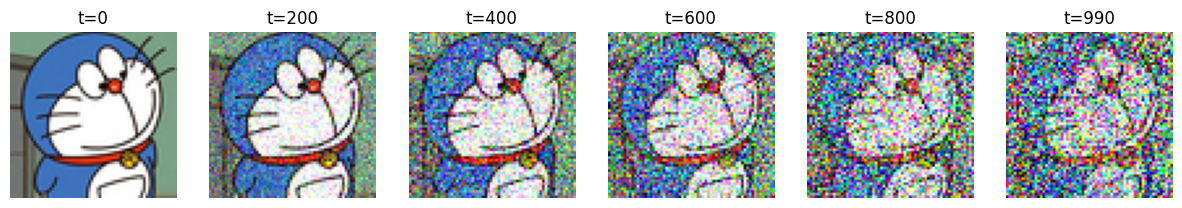

In [27]:
# 3. 可视化几个扩散步骤
steps_to_show = [0, 0.2, 0.4, 0.6, 0.8, 0.99]  # [1, 10, 100, 500, 999]
steps_to_show = [int(steps_to_show[i] * T_steps) for i in range(len(steps_to_show))]
fig, axes = plt.subplots(1, len(steps_to_show), figsize=(15, 3))

for i, t in enumerate(steps_to_show):
    xt, noise = q_sample(x0, torch.tensor([t], device=device))
    xt_img = (xt.squeeze(0).detach().cpu() * 0.5 + 0.5).clamp(0, 1)  # 还原到 [0,1]
    axes[i].imshow(xt_img.permute(1, 2, 0))
    axes[i].set_title(f"t={t}")
    axes[i].axis("off")

    if t == steps_to_show[-1]:
        xT = xt
plt.show()

In [28]:
# 4. 定义时间嵌入MLP与Tiny U-Net
import torch.nn as nn

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 128, 3, padding=1)
        self.enc3 = nn.Conv2d(128, 64, 3, padding=1)

        self.dec1 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec2 = nn.ConvTranspose2d(64, 32, 3, padding=1)
        self.out = nn.Conv2d(32, 3, 3, padding=1)

    def forward(self, x, t):
        # t ∈ [B]，先归一化到 [0,1]
        t = t.float() / T_steps  # [B]
        t = t.view(-1, 1, 1, 1)  # [B,1,1,1]

        # 扩展到与通道数相同
        t_enc1 = t.expand(-1, 32, x.size(2), x.size(3))
        t_enc2 = t.expand(-1, 128, x.size(2), x.size(3))
        t_enc3 = t.expand(-1, 64, x.size(2), x.size(3))

        x = F.relu(self.enc1(x) + t_enc1)
        x = F.relu(self.enc2(x) + t_enc2)
        x = F.relu(self.enc3(x) + t_enc3)

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        return self.out(x)



In [29]:
# 5. 训练 tiny U-Net
model = SimpleUNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-4)

n_iters = int(8e3)  # 迭代次数
best_loss = float('inf')  # 初始化最小 loss
best_model_state = None   # 保存最优模型参数

for step in range(1, n_iters + 1):
    # 随机时间步
    t = torch.randint(0, T_steps, (1,), device=device).long()
    xt, noise = q_sample(x0, t)

    # 前向预测噪声
    pred_noise = model(xt, t.float())
    loss = F.mse_loss(pred_noise, noise)

    # 反向传播
    opt.zero_grad()
    loss.backward()
    opt.step()

    # 更新最优模型
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model_state = model.state_dict()  # 保存当前最优模型参数

    # 打印训练信息
    if step % 500 == 0:
        print(f"Step {step}/{n_iters}, Loss: {loss.item():.4f}, Best Loss: {best_loss:.4f}")

# 训练完成后加载最优模型
model.load_state_dict(best_model_state)
print(f"load best model (Loss={best_loss:.4f})")


Step 500/8000, Loss: 0.4190, Best Loss: 0.1367
Step 1000/8000, Loss: 0.5794, Best Loss: 0.1130
Step 1500/8000, Loss: 0.1166, Best Loss: 0.0866
Step 2000/8000, Loss: 0.5246, Best Loss: 0.0726
Step 2500/8000, Loss: 0.0928, Best Loss: 0.0671
Step 3000/8000, Loss: 0.0724, Best Loss: 0.0671
Step 3500/8000, Loss: 0.1814, Best Loss: 0.0649
Step 4000/8000, Loss: 0.0853, Best Loss: 0.0623
Step 4500/8000, Loss: 0.0732, Best Loss: 0.0607
Step 5000/8000, Loss: 0.0759, Best Loss: 0.0586
Step 5500/8000, Loss: 0.0645, Best Loss: 0.0586
Step 6000/8000, Loss: 0.1847, Best Loss: 0.0551
Step 6500/8000, Loss: 0.0657, Best Loss: 0.0551
Step 7000/8000, Loss: 0.0687, Best Loss: 0.0551
Step 7500/8000, Loss: 0.0667, Best Loss: 0.0517
Step 8000/8000, Loss: 0.0605, Best Loss: 0.0517
load best model (Loss=0.0517)


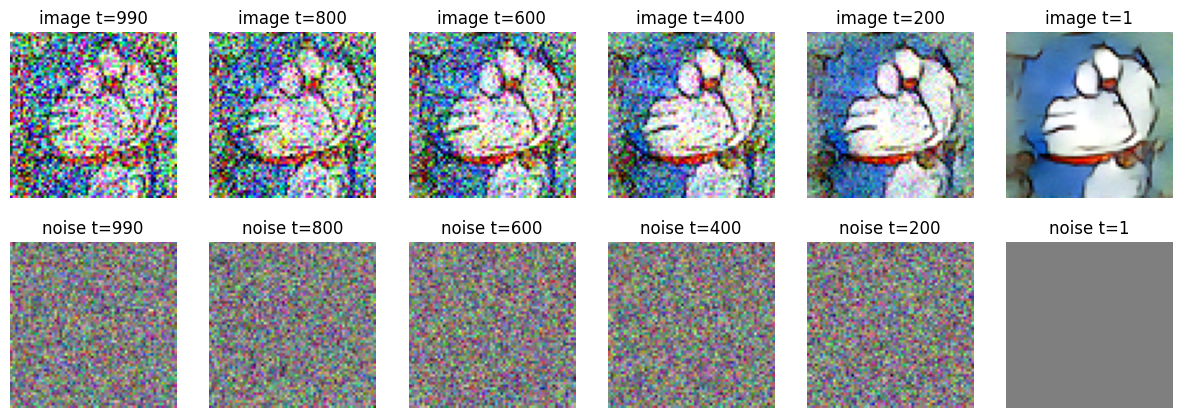

In [32]:
# 6. 反向采样展示
@torch.no_grad()
def sample_with_noise(model, steps_to_show):
    x = torch.randn(1, 3, 64, 64, device=device)  # 从纯噪声开始
    x = xT
    images = {}
    noises = {}  # 保存每一步噪声

    for t in reversed(range(T_steps)):
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        beta_t = betas[t]

        # 预测噪声
        pred_noise = model(x, torch.tensor([t], device=device).float())

        # DDPM 反向公式
        coef1 = 1 / torch.sqrt(alpha_t)
        coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        sigma_t = torch.sqrt(beta_t)

        x = coef1 * (x - coef2 * pred_noise) + sigma_t * noise

        # 保存展示图像和噪声
        if (t+1) in steps_to_show:
            img_show = (x.squeeze(0).cpu().clamp(-1,1) + 1) / 2
            images[t+1] = img_show
            noises[t+1] = (noise.squeeze(0).cpu().clamp(-3,3) + 3) / 6  # 归一化到 [0,1] 展示

    return images, noises

# ================= 生成并展示 =================
images, noises = sample_with_noise(model, [1,] + steps_to_show)
fig, axes = plt.subplots(2, len(images), figsize=(15, 5))
for i, t in enumerate(sorted(images.keys(), reverse=True)):
    # 反向采样后的图
    axes[0, i].imshow(images[t].permute(1, 2, 0))
    axes[0, i].set_title(f"image t={t}")
    axes[0, i].axis("off")

    # 对应的噪声
    axes[1, i].imshow(noises[t].permute(1, 2, 0))
    axes[1, i].set_title(f"noise t={t}")
    axes[1, i].axis("off")
plt.show()